<a href="https://colab.research.google.com/github/yoba7/Geomatics/blob/master/clustering_sur_orthophotos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Récupérer orthophotos avec owslib

[owslib](https://geopython.github.io/OWSLib/) est une librairie qui permet de récupérer des informations d'un serveur WMS, WFS, ...

In [0]:
!pip install owslib opencv-python

## Import de la librairie

In [0]:
from owslib.wms import WebMapService

## Connexion avec un serveur

Ici, je me connecte sur un serveur d'images du Service Public de Wallonie et je vérifie quels sont les formats supportés.

In [0]:
#wms = WebMapService('http://geoservices.wallonie.be/arcgis/services/IMAGERIE/ORTHO_2018/MapServer/WMSServer')
#wms = WebMapService('http://geoservices.wallonie.be/arcgis/services/IMAGERIE/ORTHO_1971/MapServer/WMSServer?request=GetCapabilities&service=WMS')
#wms = WebMapService('http://geoservices.wallonie.be/arcgis/services/IMAGERIE/ORTHO_2009_2010/MapServer/WMSServer')
wms = WebMapService('http://geoservices.wallonie.be/arcgis/services/IMAGERIE/ORTHO_2012_2013/MapServer/WMSServer')

In [0]:
list(wms.contents)

['0']

In [0]:
wms['0'].title

'Orthos'

In [0]:
wms.getOperationByName('GetMap').formatOptions

['image/bmp',
 'image/jpeg',
 'image/tiff',
 'image/png',
 'image/png8',
 'image/png24',
 'image/png32',
 'image/gif',
 'image/svg+xml']

In [0]:
wms['0'].styles

{'default': {'legend': 'http://geoservices.wallonie.be/arcgis/services/IMAGERIE/ORTHO_2012_2013/MapServer/WMSServer?request=GetLegendGraphic%26version=1.1.1%26format=image/png%26layer=0',
  'title': '0'}}

## Getmap

Récupérer une orthophoto du Châteur de La Hulpe au format JPG

In [0]:
# Chateau de La Hulpe
lowerLeftCorner=[156350,158090]
upperRightCorner=[x+300 for x in lowerLeftCorner]
myBBox=(lowerLeftCorner[0],lowerLeftCorner[1],upperRightCorner[0],upperRightCorner[1])

In [0]:
img = wms.getmap(layers=['0'],
                 srs='EPSG:31370',
                 bbox=myBBox,
                 size=(800, 800),
                 format='image/jpeg',
                 transparent=True
                 )
out = open('chateau.jpg', 'wb')
out.write(img.read())
out.close()

# Traitements d'images avec PIL

[Pillow](https://pillow.readthedocs.io/en/latest/handbook/tutorial.html) est une librairie qui permet de faire des traitements d'images. PIL est l'acronyme de Python Imaging Library.




## Charger une image en mémoire

In [0]:
from PIL import Image
img = Image.open('chateau.jpg')

## Taille de l'image

In [0]:
img.size

(800, 800)

## Visualiser l'image

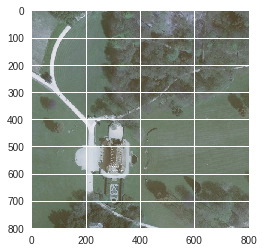

In [0]:
%matplotlib inline
from matplotlib.pyplot import imshow 
import numpy as np
imshow(img)

## Transformer le RGB en HSV

HSV=[Hue Saturation Value](https://fr.wikipedia.org/wiki/Teinte_Saturation_Valeur)
- Hue:
    - Couleur de l'arc-en-ciel
    - Du rouge (Hue=0) vers le violet
    - L'infrarouge et l'ultraviolet n'ont pas leur place dans cette échelle -> uniquement pour les couleurs visibles
    - $H \in [0°,180°[$
- Saturation:
     - Intensité
     - $S \in [0,1]$
     - D'autant plus grand que l'on s'écarte du blanc, qui est la couleur qui intègre toutes les aures couleurs
     - $\frac{max(R,G,B)-min(R,G,B)}{max(R,G,B)}$
     - opencv --> 0 jusque 255
- Valeur:
    - Brillance (0=noir)
    - $max(R,G,B)$
    - $S \in [0,256]$
    - opencv --> 0 jusque 255
    
Voir aussi articles:
   - [Colour Rendering of Spectra](http://www.fourmilab.ch/documents/specrend/)
   - [Hue, Value, Saturation](http://learn.leighcotnoir.com/artspeak/elements-color/hue-value-saturation/)

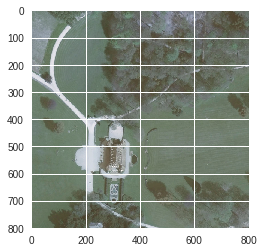

In [0]:
import cv2
import numpy as np

## Read
img = cv2.imread("chateau.jpg")

## convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

## Vérifier que la transformation inverse fonctionne correctement
imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))

## Visualiser la distribution de HUE avec matplotlib

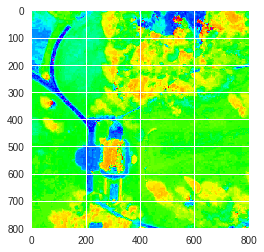

In [0]:
from matplotlib.pyplot import imshow 

hue=hsv.copy()
hue[:,:,1]=255
hue[:,:,2]=255

imshow(cv2.cvtColor(hue, cv2.COLOR_HSV2RGB))

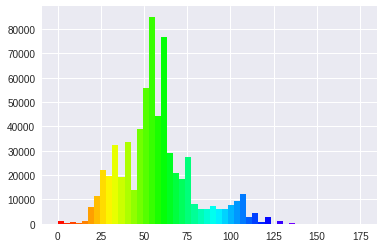

In [0]:
import matplotlib.pyplot as plt

hue=hsv[:,:,0].flatten().tolist()

n, bins, patches = plt.hist(hue, 50)

bin_centers = (bins[:-1] + bins[1:])/2

col = bin_centers/180

cm = plt.cm.get_cmap('hsv')
#cm = plt.cm.get_cmap('gist_rainbow')
#cm = plt.cm.hsv

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
    
plt.show()

## Sélectionner portion d'image sur base de HUE

Sélectionner le chemin en dolomie (bleu).

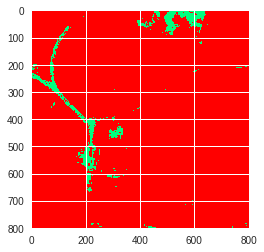

In [0]:
seuil1=105
seuil2=130
image=hsv.copy()
image[:,:,0]=(((hsv[:,:,0]<seuil2)*1+(hsv[:,:,0]>seuil1)*1)==2)*75
image[:,:,1]=255
image[:,:,2]=255
imshow(cv2.cvtColor(image, cv2.COLOR_HSV2RGB))

## Matrice d'histogrammes pour HUE, SATURATION, VALUE

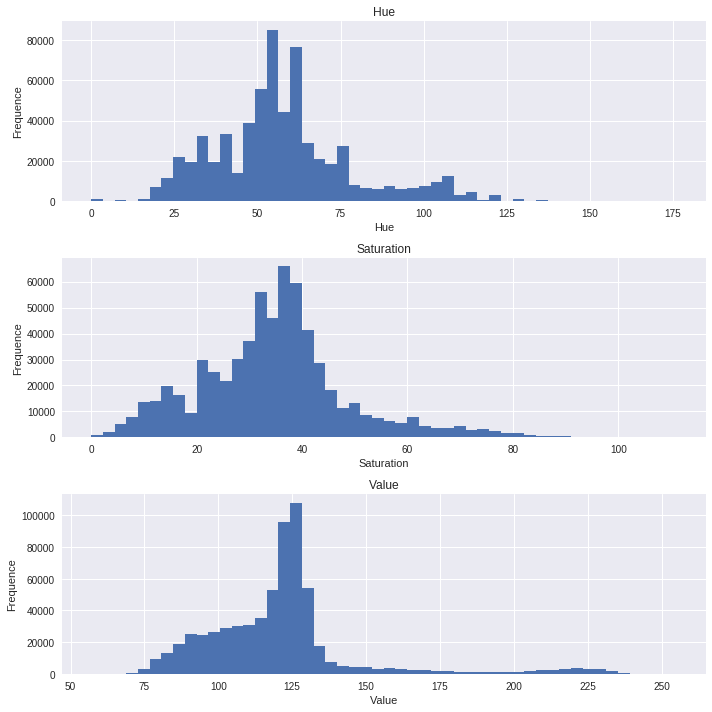

In [0]:
titles=['Hue','Saturation','Value']
f,a = plt.subplots(3,1,figsize=(10, 10))
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(hsv[:,:,idx].flatten().tolist(),50)
    ax.set_title(titles[idx])
    ax.set_xlabel(titles[idx])
    ax.set_ylabel('Frequence')
plt.tight_layout()


 # Transformer image en DataFrame

In [0]:
import pandas as pd
myImageDF=pd.DataFrame({'Hue':       hsv[:,:,0].flatten().tolist(),
                        'Saturation':hsv[:,:,1].flatten().tolist(), 
                        'Value':     hsv[:,:,2].flatten().tolist()})
myImageDF.head()

,Hue,Saturation,Value
0,77,28,129
1,77,28,128
2,77,28,128
3,77,28,127
4,77,28,129


# Clustering

## Calculs

In [0]:
countOfClusters=4

In [0]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=countOfClusters)
kmeans.fit(myImageDF)

clusters = kmeans.predict(myImageDF)

## Ajouter une colonne au DataFrame avec le cluster de chaque point

In [0]:
myImageDF['Cluster']=clusters
myImageDF.head()

,Hue,Saturation,Value,Cluster
0,77,28,129,3
1,77,28,128,0
2,77,28,128,0
3,77,28,127,0
4,77,28,129,3


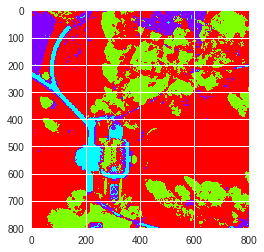

In [0]:
image=hsv.copy()
image[:,:,0]=clusters.reshape(800,800)/countOfClusters*180
image[:,:,1]=255
image[:,:,2]=255
imshow(cv2.cvtColor(image, cv2.COLOR_HSV2RGB))

## Portion de territoire occupée par chaque couleur

In [0]:
myImageDF['Cluster'].value_counts()

0    410735
1    145770
3     55118
2     28377
Name: Cluster, dtype: int64

In [0]:
myImageDF['Cluster'].value_counts()/myImageDF['Cluster'].count()

0    0.641773
1    0.227766
3    0.086122
2    0.044339
Name: Cluster, dtype: float64

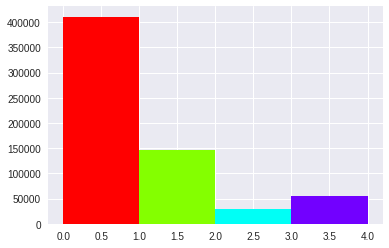

In [0]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(clusters,bins=range(countOfClusters+1))

col = bins[:-1]/countOfClusters

cm = plt.cm.get_cmap('hsv')

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
    
plt.show()